In [8]:
#Preparar as bibliotecas que serão usadas na analise
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Configurando o estilo dos gráficos 
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

try:
    df = pd.read_csv('desafio_indicium_imdb.csv')
except FileNotFoundError:
    print("Arquivo não encontrado. Verifique o nome e o caminho do arquivo.")
    # Encerre o script ou lide com o erro como preferir
    exit()


# --- LIMPEZA E PREPARAÇÃO DOS DADOS ---
# Remove a coluna 'Unnamed: 0', que é apenas um índice duplicado
df.drop('Unnamed: 0', axis=1, inplace=True)

# Limpa a coluna 'Runtime' removendo o sufixo " min" e convertendo para inteiro
df['Runtime'] = df['Runtime'].str.replace(' min', '').astype(int)

# Limpa a coluna 'Gross' removendo vírgulas e convertendo para float
# 'errors=coerce' transforma valores inválidos em NaN (Not a Number)
df['Gross'] = df['Gross'].str.replace(',', '', regex=False).astype(float)

# Converte a coluna 'Released_Year' para um tipo numérico
# 'errors=coerce' lida com possíveis valores não numéricos que possam existir
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')

mapeamento_colunas = {
    'Series_Title': 'Titulo',
    'Released_Year': 'Ano_Lancamento',
    'Certificate': 'Certificado',
    'Runtime': 'Duracao_Min',
    'Genre': 'Genero',
    'IMDB_Rating': 'Nota_IMDB',
    'Overview': 'Resumo',
    'Meta_score': 'Nota_Metascore',
    'Director': 'Diretor',
    'Star1': 'Estrela1',
    'Star2': 'Estrela2',
    'Star3': 'Estrela3',
    'Star4': 'Estrela4',
    'No_of_Votes': 'Num_Votos',
    'Gross': 'Faturamento'
}

# Renomear as colunas usando o método .rename()
df.rename(columns=mapeamento_colunas, inplace=True)


In [9]:
# 2a. Qual filme você recomendaria para uma pessoa que você não conhece?
# Calcular a média entre IMDB Rating e Meta Score
df['IMDB_Meta_med'] = (df['Nota_IMDB'] + (df['Nota_Metascore'] / 10)) / 2
# Selecionar o filme com a maior média
filme_recomendado = df.loc[df['IMDB_Meta_med'].idxmax()]
print(f"Filme recomendado: {filme_recomendado['Titulo']}")
print(f"IMDB Rating: {filme_recomendado['Nota_IMDB']}")
print(f"Meta Score: {filme_recomendado['Nota_Metascore']}")

Filme recomendado: The Godfather
IMDB Rating: 9.2
Meta Score: 100.0


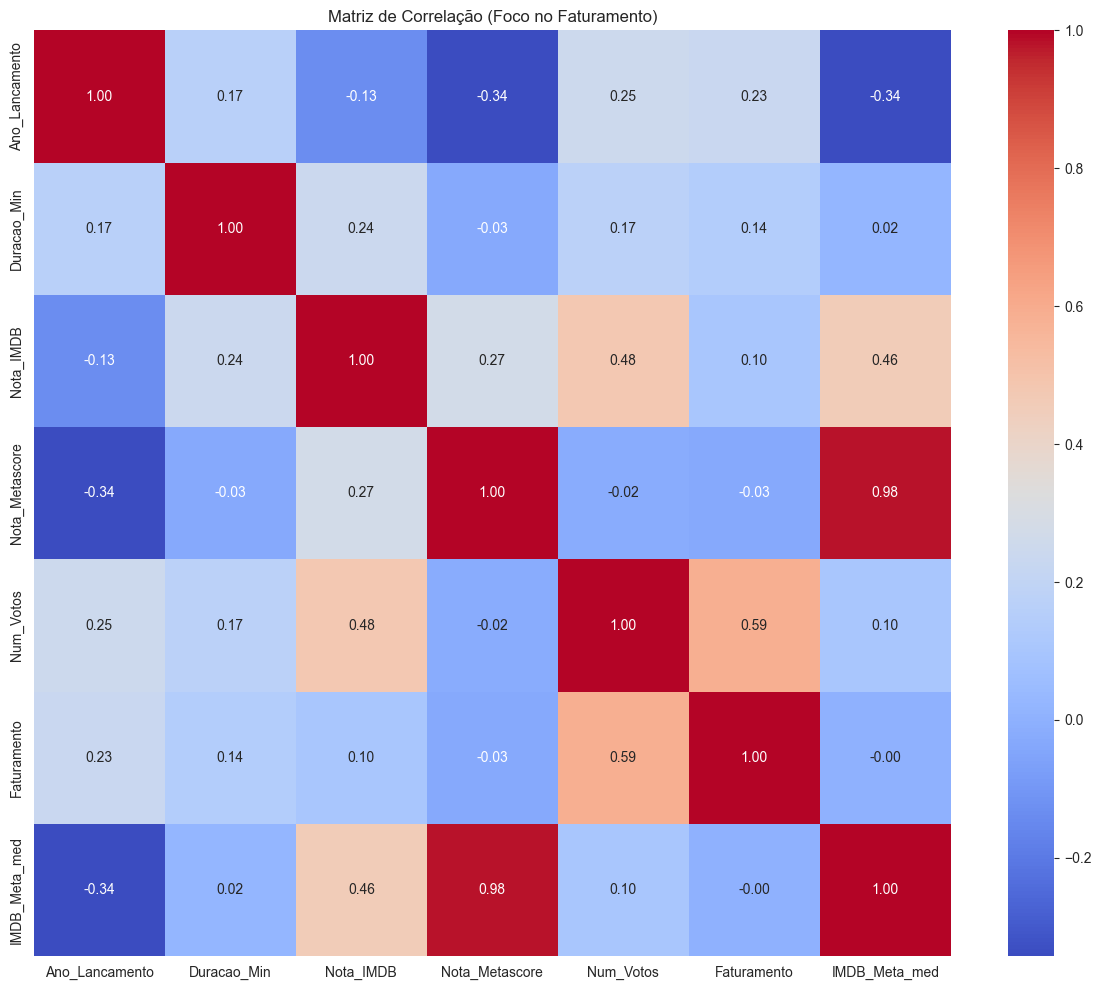

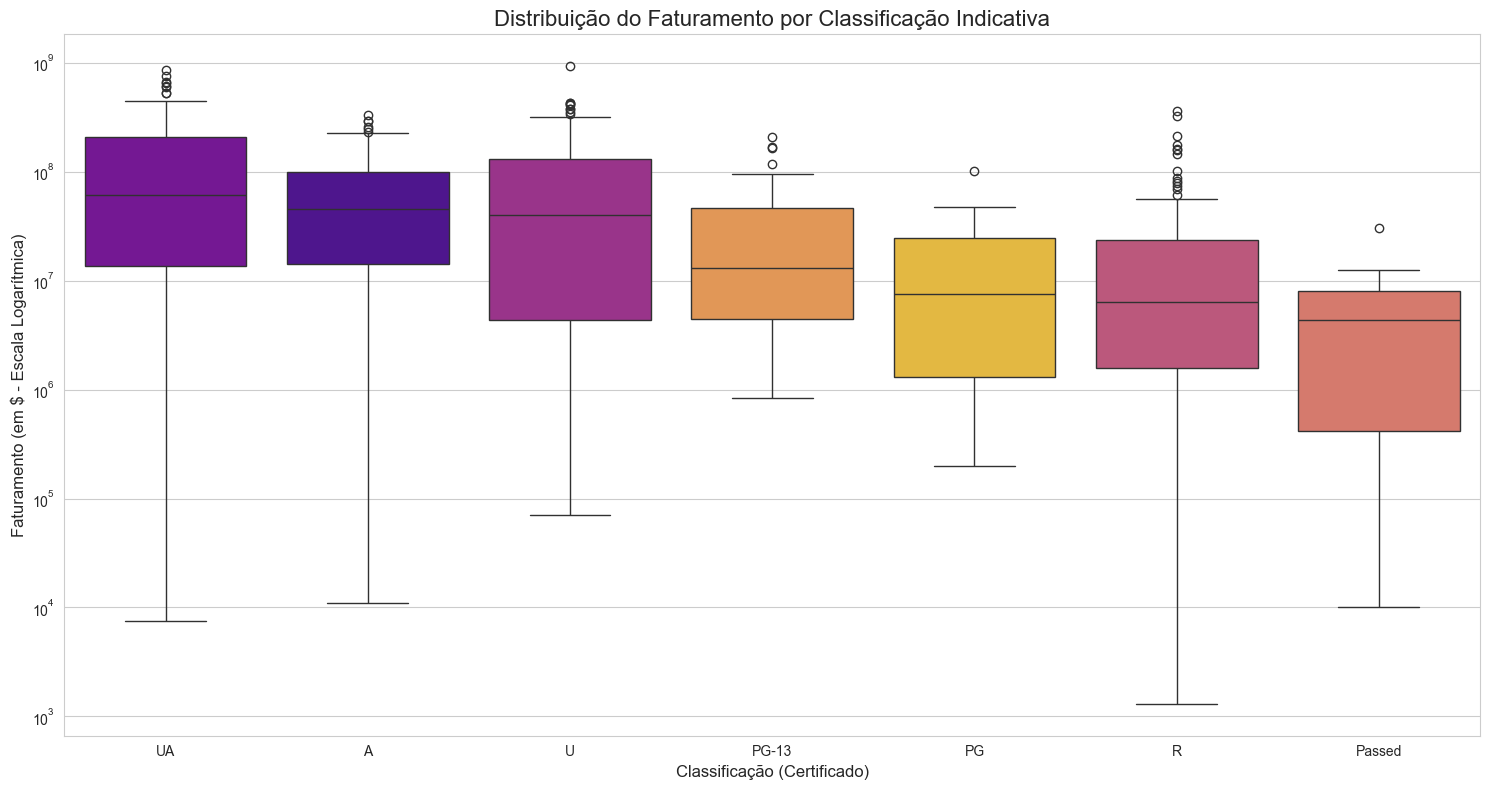

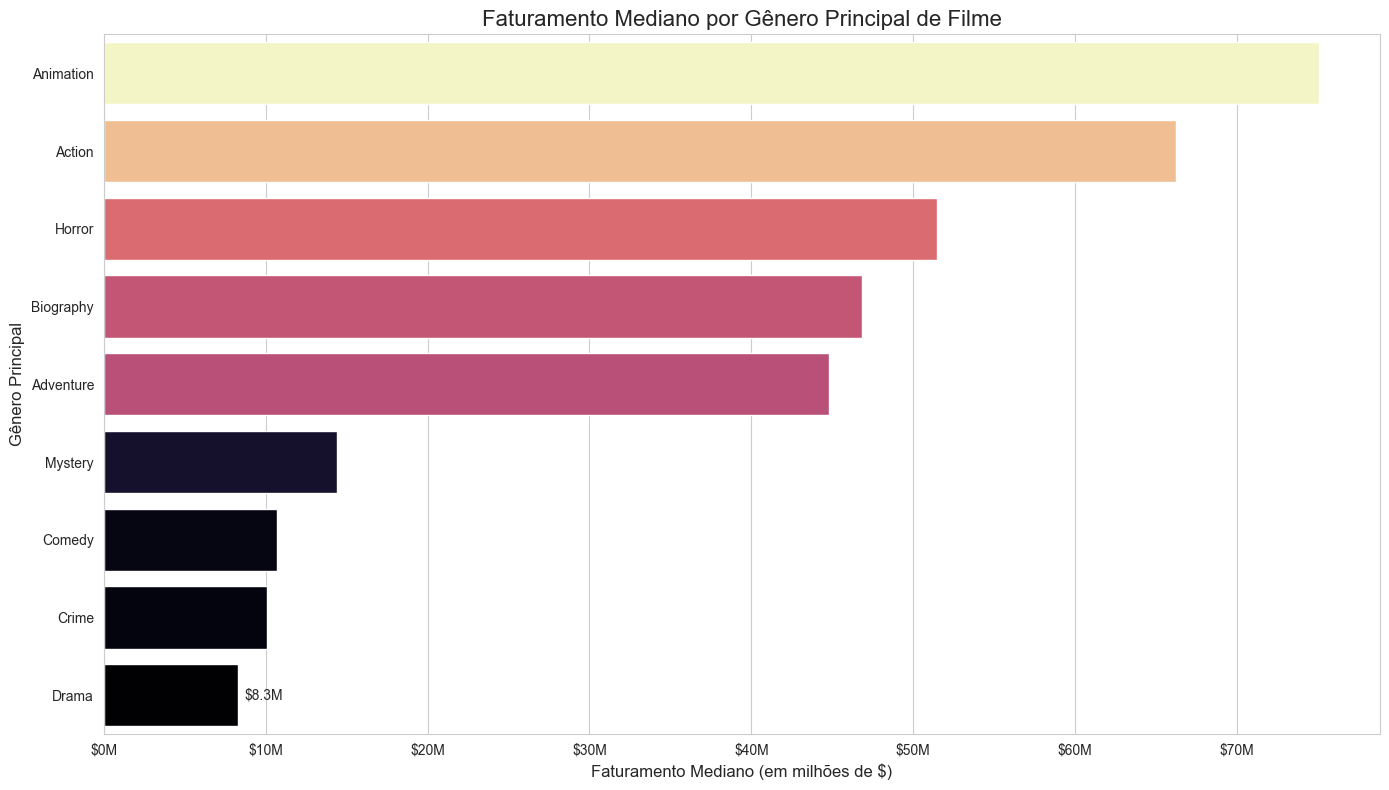

In [10]:
# 2b. Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

#podemos realisar uma analise dos dados numericos e encontrar sua correlação com o faturamento de um filme, para isso:
plt.figure(figsize=(12, 10))
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação (Foco no Faturamento)')
plt.tight_layout()
plt.show()

#Tambem realizamos uma analise de variaveis categoricas como a Classiicação indicativa
# Remover filmes com dados de 'Certificado' ou 'Faturamento' ausentes para esta análise
df_certificado = df.dropna(subset=['Certificado', 'Faturamento'])

# Contar quantos filmes existem por certificado para garantir relevância
certificados_comuns = df_certificado['Certificado'].value_counts()
# Manter apenas certificados com um número razoável de filmes 
certificados_filtrados = certificados_comuns[certificados_comuns > 10].index
df_certificado_filtrado = df_certificado[df_certificado['Certificado'].isin(certificados_filtrados)]

# Ordenar os certificados pela mediana do faturamento
order_cert = df_certificado_filtrado.groupby('Certificado')['Faturamento'].median().sort_values(ascending=False).index


plt.figure(figsize=(15, 8))
sns.boxplot(data=df_certificado_filtrado, x='Certificado', y='Faturamento', order=order_cert, palette='plasma', hue = 'Certificado', legend=False)

# Usar escala logarítmica no eixo Y para melhor visualização da distribuição do faturamento
plt.yscale('log')

plt.title('Distribuição do Faturamento por Classificação Indicativa', fontsize=16)
plt.xlabel('Classificação (Certificado)', fontsize=12)
plt.ylabel('Faturamento (em $ - Escala Logarítmica)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

#E tambem genero--
# Criar a nova coluna no DataFrame principal 
df['Genero_Principal'] = df['Genero'].apply(lambda x: str(x).split(',')[0])

# Agora, criar a fatia a partir do DF já modificado
df_genero_fat = df.dropna(subset=['Faturamento'])

# Calcular a mediana do faturamento
median_faturamento_por_genero = df_genero_fat.groupby('Genero_Principal')['Faturamento'].median()

# Contar o número de filmes em cada gênero
contagem_genero = df_genero_fat['Genero_Principal'].value_counts()

# Juntar os dados de mediana e contagem
df_genero_agg = pd.DataFrame({'Faturamento_Mediano': median_faturamento_por_genero, 'Contagem': contagem_genero})

# Filtrar gêneros com poucos filmes (mais de 5)
df_genero_filtrado = df_genero_agg[df_genero_agg['Contagem'] > 5]

# Ordenar os gêneros pelo faturamento mediano
df_genero_ordenado = df_genero_filtrado.sort_values('Faturamento_Mediano', ascending=False)

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

barplot = sns.barplot(x=df_genero_ordenado['Faturamento_Mediano'], y=df_genero_ordenado.index, palette='magma', hue=df_genero_ordenado['Faturamento_Mediano'],legend=False)

# Customização
plt.title('Faturamento Mediano por Gênero Principal de Filme', fontsize=16)
plt.xlabel('Faturamento Mediano (em milhões de $)', fontsize=12)
plt.ylabel('Gênero Principal', fontsize=12)

def millions_formatter(x, pos):
    return f'${int(x/1000000)}M'
barplot.xaxis.set_major_formatter(FuncFormatter(millions_formatter))

barplot.bar_label(
    barplot.containers[0],
    fmt=lambda x: f'${x/1000000:.1f}M', 
    padding=5
)
plt.tight_layout()
plt.show()


In [ ]:
"""
Apartir das analises tem-se as seguintes conclusões:
1.Popularidade e Engajamento (Número de Votos): Este é o fator com a correlação mais forte com o faturamento.
2.Classificação Indicativa Ampla (Certificado): Filmes com classificações mais abrangentes, como "U" (Livre) e "UA" (equivalente a +12/+13), têm um 
potencial de faturamento muito superior. 
3.Qualidade Percebida (Notas): Embora uma nota altíssima não garanta o sucesso, um filme precisa ser percebido como "bom o suficiente". A análise
mostra que os maiores blockbusters se concentram em uma faixa de Metascore entre 65 e 85.
4.Gênero de Grande Apelo: Os filmes de maior faturamento são predominantemente dos gêneros Animação, Ação e terror
"""

In [ ]:
# 2c. Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?
# podemos usar esse modelo simples para prever com certa precisão o gênero de um filme


In [11]:
# Importar bibliotecas
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.corpus import stopwords
import nltk

# Baixar stopwords (se ainda não tiver)
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

In [14]:
# limpar dados
df = df.dropna(subset=['Resumo', 'Genero'])
df = df.drop_duplicates(subset=['Resumo'])

# Pré-processamento do Texto
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return ' '.join(word for word in text.split() if word not in stop_words)

df['resumo_limpo'] = df['Resumo'].apply(preprocess_text)

# Preparar Labels (Gêneros) para Classificação Multi-Label
df['genero_lista'] = df['Genero'].apply(lambda x: [genre.strip() for genre in x.split(',')])

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genero_lista'])

# Divisão em Treino e Teste (80% treino, 20% teste)
X = df['resumo_limpo']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Vetorização do Texto (TF-IDF com n-gramas)
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Treinamento do Modelo
# Usando a Regressão Logística com 'class_weight' para lidar com o desbalanceamento
logreg = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', C=1.0)
ovr_classifier = OneVsRestClassifier(logreg)
ovr_classifier.fit(X_train_tfidf, y_train)

# Avaliação do Modelo
y_pred = ovr_classifier.predict(X_test_tfidf)
report = classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0)
print("--- Relatório de Classificação ---")
print(report)

# Exemplo de Previsão para um Novo Resumo
print("\n--- Exemplo de Previsão para um Novo Resumo ---")
novo_resumo = "A thief who steals corporate secrets through the use of dream-sharing technology is given the inverse task of planting an idea into the mind of a C.E.O."
novo_resumo_clean = preprocess_text(novo_resumo)
novo_resumo_tfidf = vectorizer.transform([novo_resumo_clean])
previsao_binaria = ovr_classifier.predict(novo_resumo_tfidf)
previsao_generos = mlb.inverse_transform(previsao_binaria)
print(f"Resumo: '{novo_resumo}'")
print(f"Gêneros Previstos: {previsao_generos[0]}")

--- Relatório de Classificação ---
              precision    recall  f1-score   support

      Action       0.48      0.29      0.36        34
   Adventure       0.71      0.25      0.37        40
   Animation       0.60      0.17      0.26        18
   Biography       0.46      0.24      0.32        25
      Comedy       0.39      0.24      0.30        46
       Crime       0.60      0.35      0.44        43
       Drama       0.84      0.88      0.86       157
      Family       0.00      0.00      0.00         5
     Fantasy       0.00      0.00      0.00         9
   Film-Noir       0.00      0.00      0.00         3
     History       0.00      0.00      0.00         8
      Horror       1.00      0.10      0.18        10
       Music       0.50      0.22      0.31         9
     Musical       0.00      0.00      0.00         4
     Mystery       0.71      0.22      0.33        23
     Romance       0.25      0.14      0.18        21
      Sci-Fi       1.00      0.18      0.31   

In [ ]:
#3.Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

In [ ]:
"""
O problema é classificado como regressão devido à natureza contínua da variável alvo, a nota (IMDB_Rating), que varia de 0 a 10.

------------------------------------------------------------------------------------------------------------------------------------------------------

O modelo foi construído com as seguintes variáveis preditoras, cada uma submetida a transformações específicas para otimizar o desempenho do algoritmo:

IMDB_Rating: Variável de resposta (target).

Gross (Receita): Uma variável numérica com uma distribuição assimétrica, caracterizada por um grande número de valores baixos e alguns valores
extremamente altos. Para mitigar o impacto desses outliers e linearizar a relação, foi aplicada a transformação logarítmica (np.log1p).

Genre (Gênero) e Director (Diretor): Variáveis categóricas, convertidas em formato numérico através do One-Hot Encoding. Para o gênero, foi extraído 
apenas o valor principal (Genre_main) antes da codificação, uma vez que cada filme pode ter múltiplos gêneros.

No_of_Votes (Número de Votos) e Meta_score: Variáveis numéricas que representam, respectivamente, a popularidade e a avaliação da crítica. Ambas foram
padronizadas utilizando o StandardScaler, o que garante que as variáveis com escalas diferentes contribuam de forma equitativa para o modelo, 
evitando que uma domine a outra.

------------------------------------------------------------------------------------------------------------------------------------------------------

O algoritmo escolhido para a modelagem de regressão foi o Random Forest Regressor, um modelo de ensemble que se mostrou a opção mais adequada devido 
aos seguintes aspectos:

Vantagens: Este modelo é altamente eficaz na captura de relações não-lineares e complexas entre as variáveis. Sua robustez e baixa sensibilidade a 
outliers e overfitting o tornam uma escolha superior em comparação com modelos lineares mais simples.

Desvantagens: Sua principal limitação reside na interpretabilidade. A natureza de "caixa preta" do algoritmo dificulta a análise direta da contribuição
de cada variável individual.

------------------------------------------------------------------------------------------------------------------------------------------------------

A performance do modelo foi avaliada com duas métricas-chave, apropriadas para problemas de regressão:

Erro Quadrático Médio (MSE - Mean Squared Error): O valor de 0.0462 indica que as previsões do modelo têm um erro médio muito baixo em relação aos 
valores reais, demonstrando um ajuste preciso aos dados de teste.

Coeficiente de Determinação (R^2): Com um valor de 0.4347, o modelo explica aproximadamente 43,5% da variabilidade na nota do IMDB. Este resultado
demonstra um poder preditivo significativo, embora a variância residual sugira a influência de outros fatores não incluídos no modelo.
"""

In [23]:
#4. Prever a nota IMDb de The Shawshank Redemption
import pickle
import numpy as np

# Carregar o modelo salvo
try:
    with open('modelo_preditivo_imdb.pkl', 'rb') as file:
        model_pipeline = pickle.load(file)
except FileNotFoundError:
    print("Erro: O arquivo 'modelo_regressao.pkl' não foi encontrado.")
    print("Por favor, execute o código de treinamento do modelo primeiro para gerar o arquivo.")

def prever_nota_nova_entrada(dados_filme):
    """
    Prevê a nota IMDB de um filme a partir de um dicionário de dados.
    """
    try:
        # Criar um DataFrame a partir do dicionário de dados do novo filme
        filme_novo = pd.DataFrame([dados_filme])

        # Aplicar as mesmas transformações de dados do pipeline de treinamento
        # Assegurar que 'Gross' seja um número e aplicar a transformação logarítmica
        filme_novo.loc[:, 'Gross'] = filme_novo['Gross'].apply(
            lambda x: float(re.sub(r'[,.]', '', str(x))) if isinstance(x, str) else float(x))
        
        # Extrair o gênero principal
        filme_novo.loc[:, 'Genre_main'] = filme_novo['Genre'].apply(lambda x: x.split(',')[0].strip())

        # Recriar o DataFrame de features na ordem correta
        features_para_prever = pd.DataFrame({
            'Genre_main': [filme_novo['Genre_main'].iloc[0]],
            'Director': [filme_novo['Director'].iloc[0]],
            'Gross_log': [np.log1p(filme_novo['Gross'].iloc[0])],
            'No_of_Votes': [filme_novo['No_of_Votes'].iloc[0]],
            'Meta_score': [filme_novo['Meta_score'].iloc[0]]
        })

        # Fazer a previsão
        previsao_nota = model_pipeline.predict(features_para_prever)
        print(f"\nNota IMDB prevista para '{dados_filme['Series_Title']}': {previsao_nota[0]:.2f}")

    except Exception as e:
        print(f"Ocorreu um erro durante a previsão: {e}")

# Dados do filme "The Shawshank Redemption"
dados_shawshank = {
    'Series_Title': 'The Shawshank Redemption',
    'Genre': 'Drama',
    'Director': 'Frank Darabont',
    'Gross': '28,341,469',
    'No_of_Votes': 2343110,
    'Meta_score': 80.0
}

# Fazer a previsão para o novo filme
prever_nota_nova_entrada(dados_shawshank)


Nota IMDB prevista para 'The Shawshank Redemption': 8.81
